In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image

In [5]:
X = [] 
y = [] 
classes = 43
current_path = os.getcwd()
for i in range(classes):
    path = os.path.join(current_path, 'TrafficSignRecognition', 'Train', str(i))
    images = os.listdir(path)
    for img_name in images:
        image = Image.open(path + '\\' + img_name)
        image = image.resize((30, 30))
        image = np.array(image)
        X.append(image)
        y.append(i)
X = np.array(X)
y = np.array(y)

In [6]:
X.shape

(39209, 30, 30, 3)

In [7]:
def train_test_split(data, labels, test_size=0.2, random_state=0):
    np.random.seed(random_state)
    N = labels.shape[0]
    idx = np.random.permutation(N)
    train_size = int(np.ceil((1-test_size)*N))
    X_train = data[idx[:train_size]]
    y_train = labels[idx[:train_size]]
    X_test = data[idx[train_size:]]
    y_test = labels[idx[train_size:]]
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=113)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (31368, 30, 30, 3)
X_test shape: (7841, 30, 30, 3)
y_train shape: (31368,)
y_test shape: (7841,)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5) 
        self.conv2 = nn.Conv2d(32, 32, 5) 
        self.pool1 = nn.MaxPool2d(2,2)  
        self.dropout1 = nn.Dropout(0.25) 
        self.conv3 = nn.Conv2d(32, 64, 3) 
        self.conv4 = nn.Conv2d(64, 64, 3) 
        self.pool2 = nn.MaxPool2d(2,2) 
        self.dropout2 = nn.Dropout(0.25) 
        self.fc1 = nn.Linear(3*3*64,256)
        self.dropout3 = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(256, 43) 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.view(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [12]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=43, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [14]:
X_train_tensor = torch.from_numpy(np.transpose(X_train, (0, 3, 1, 2))).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_val_tensor = torch.from_numpy(np.transpose(X_test, (0, 3, 1, 2))).float()
y_val_tensor = torch.from_numpy(y_test).long()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(dataset=train_data, batch_size=64)
val_dataloader = DataLoader(dataset=val_data, batch_size=64)
dataloaders = {'train': train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train': len(X_train), 'val': len(X_test)}

In [15]:
def train_model(model, criterion, optimizer, dataset_sizes, num_epochs=15):
    since = time.time()
    epoch_loss = []
    epoch_acc = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
            i = 0
            running_loss = 0.0
            running_corrects = 0
            if phase == 'train':
                 print(f'\rProgress:',end='')
            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train' and i % 50 == 49:
                    print(f"\rProgress: [{'='*((i+1)//50)}] ",end='')
                i += 1                        
            epoch_loss.append(running_loss / dataset_sizes[phase])
            epoch_acc.append(running_corrects.numpy() / dataset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss[-1], epoch_acc[-1]))
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return epoch_loss, epoch_acc

In [16]:
epoch_loss, epoch_acc = train_model(model, criterion, optimizer, dataset_sizes, num_epochs=15)

Epoch 0/14
----------
Progress: [=========] train Loss: 0.0293 Acc: 0.4941
val Loss: 0.0067 Acc: 0.9066

Epoch 1/14
----------
Progress: [=========] train Loss: 0.0088 Acc: 0.8394
val Loss: 0.0031 Acc: 0.9597

Epoch 2/14
----------
Progress: [=========] train Loss: 0.0056 Acc: 0.8991
val Loss: 0.0020 Acc: 0.9699

Epoch 3/14
----------
Progress: [=========] train Loss: 0.0043 Acc: 0.9242
val Loss: 0.0017 Acc: 0.9774

Epoch 4/14
----------
Progress: [=========] train Loss: 0.0036 Acc: 0.9362
val Loss: 0.0013 Acc: 0.9779

Epoch 5/14
----------
Progress: [=========] train Loss: 0.0031 Acc: 0.9426
val Loss: 0.0008 Acc: 0.9889

Epoch 6/14
----------
Progress: [=========] train Loss: 0.0029 Acc: 0.9477
val Loss: 0.0007 Acc: 0.9904

Epoch 7/14
----------
Progress: [=========] train Loss: 0.0031 Acc: 0.9453
val Loss: 0.0008 Acc: 0.9879

Epoch 8/14
----------
Progress: [=========] train Loss: 0.0029 Acc: 0.9483
val Loss: 0.0007 Acc: 0.9898

Epoch 9/14
----------
Progress: [=========] train Loss:

In [17]:
accuracy = epoch_acc[::2]
val_accuracy = epoch_acc[1::2]
loss = epoch_loss[::2]
val_loss = epoch_loss[1::2]

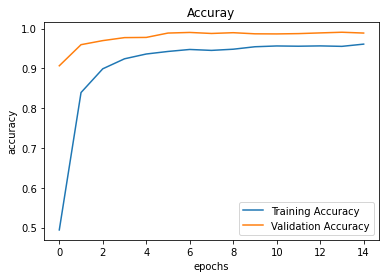

In [18]:
plt.figure()
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.title('Accuray')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

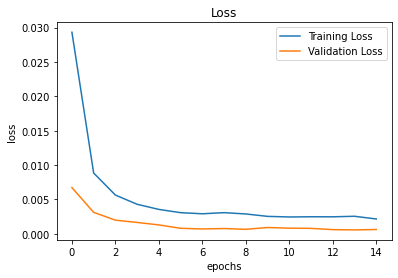

In [19]:
plt.figure()
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [26]:
torch.save(model.state_dict(), 'model.pt')

In [22]:
N = 5000
import pandas as pd
current_path = os.getcwd()
test_model_data = pd.read_csv(open(os.path.join(current_path, 'TrafficSignRecognition', 'Test.csv'), "rb"))
y_test_labels = test_model_data['ClassId'][:N]
img_paths = test_model_data['Path'][:N]
x_test_labels = []
for img in img_paths:
    image = Image.open(os.path.join(current_path, 'TrafficSignRecognition',img))
    image = image.resize((30,30))
    x_test_labels.append(np.array(image))
x_test_labels = np.array(x_test_labels)

In [23]:
X_test_labels_tensor = torch.from_numpy(np.transpose(x_test_labels, (0, 3, 1, 2))).float()
y_test_labels_tensor = torch.from_numpy(y_test_labels.values).long()

In [24]:
model.eval()
y_test_outputs = model(X_test_labels_tensor)
_, y_test_preds = torch.max(y_test_outputs, 1)
acc = torch.sum(y_test_preds == y_test_labels_tensor.data).float()/len(y_test_labels)
print(f"{acc:.2%}")

95.70%
